# **Extracting Bag of Words (BoW) Features and Building a Similarity Matrix**


### Importing Libraries and Loading the dataset


In [32]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from scipy.spatial.distance import cosine

In [34]:
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"
course_content_df = pd.read_csv(course_url)

In [35]:
course_content_df.head()

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...


In [36]:
# Merge TITLE and DESCRIPTION title
course_content_df['course_texts'] = course_content_df[['TITLE', 'DESCRIPTION']].agg(' '.join, axis=1)
course_content_df.head()

,COURSE_ID,TITLE,DESCRIPTION,course_texts
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...,robots are coming build iot apps with watson ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...,accelerating deep learning with gpu training c...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...,consuming restful services using the reactive ...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...,analyzing big data in r using apache spark apa...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...,containerizing packaging and running a sprin...


### Bag of Words (BoW) features


In [38]:
def tokenize_course(course, keep_only_nouns=True):
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    # Tokenize the course text
    word_tokens = word_tokenize(course)
    # Remove English stop words and numbers
    word_tokens = [w for w in word_tokens if (not w.lower() in stop_words) and (not w.isnumeric())]
    # Only keep nouns 
    if keep_only_nouns:
        # Define a filter list of non-noun POS tags
        filter_list = ['WDT', 'WP', 'WRB', 'FW', 'IN', 'JJR', 'JJS', 'MD', 'PDT', 'POS', 'PRP', 'RB', 'RBR', 'RBS',
                       'RP']
        # Tag the word tokens with POS tags
        tags = nltk.pos_tag(word_tokens)
        # Filter out non-nouns based on POS tags
        word_tokens = [word for word, pos in tags if pos not in filter_list]

    return word_tokens

In [39]:
# Tokenizing the course texts
tokenized_courses = [tokenize_course(course, keep_only_nouns=True) for course in course_content_df['course_texts']]
tokenized_courses[0]

['robots',
 'coming',
 'build',
 'iot',
 'apps',
 'watson',
 'swift',
 'red',
 'fun',
 'iot',
 'learn',
 'way',
 'swift',
 'developer',
 'want',
 'learn',
 'iot',
 'watson',
 'ai',
 'services',
 'cloud',
 'raspberry',
 'pi',
 'node',
 'red',
 'found',
 'place',
 'build',
 'iot',
 'apps',
 'read',
 'temperature',
 'data',
 'take',
 'pictures',
 'raspcam',
 'use',
 'ai',
 'recognize',
 'objects',
 'pictures',
 'program',
 'irobot',
 'create',
 'robot']

In [40]:
# Creating a token dictionary for the course texts
tokens_dict = gensim.corpora.Dictionary(tokenized_courses)
print(dict(list(tokens_dict.token2id.items())[0:10]))

{'ai': 0, 'apps': 1, 'build': 2, 'cloud': 3, 'coming': 4, 'create': 5, 'data': 6, 'developer': 7, 'found': 8, 'fun': 9}


In [41]:
# Generating BoW features for each course
courses_bow = [tokens_dict.doc2bow(course) for course in tokenized_courses]
courses_bow[0]

[(0, 2),
 (1, 2),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 4),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 2),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1)]

In [42]:
# Creating a new course_bow dataframe based on the extracted BoW features
bow_dicts_list = []

for course_idx, course_bow in enumerate(courses_bow):
    doc_indices = course_idx
    doc_ids = course_content_df.loc[course_idx, 'COURSE_ID']

    for token_index, token_bow in course_bow:
        tokens = tokens_dict.get(token_index)
        bow_values = token_bow
        bow_dicts = {
                     "doc_id": doc_ids,
                     "token": tokens,
                     "bow": bow_values}
        bow_dicts_list.append(bow_dicts)

bows_df = pd.DataFrame(bow_dicts_list)

In [43]:
bows_df

,doc_id,token,bow
0,ML0201EN,ai,2
1,ML0201EN,apps,2
2,ML0201EN,build,2
3,ML0201EN,cloud,1
4,ML0201EN,coming,1
...,...,...,...
10358,excourse93,modifying,1
10359,excourse93,objectives,1
10360,excourse93,pieces,1
10361,excourse93,plugins,1


### Building a Similarity Matrix using Cosine Similarity


In [45]:
courses = set(bows_df["doc_id"].to_list())
len(courses)

307

In [46]:
def pivot_two_bows(basedoc, comparedoc):
    
    # Create copies of the input DataFrames to avoid modifying the originals
    base = basedoc.copy()
    base['type'] = 'base'  # Add a 'type' column indicating base document
    compare = comparedoc.copy()
    compare['type'] = 'compare'  # Add a 'type' column indicating compared document

    # Concatenate the two DataFrames vertically
    join = pd.concat([base, compare])

    # Pivot the concatenated DataFrame based on 'doc_id' and 'type', with words as columns
    joinT = join.pivot(index=['doc_id', 'type'], columns='token').fillna(0).reset_index(level=[0, 1])

    # Assign meaningful column names to the pivoted DataFrame
    joinT.columns = ['doc_id', 'type'] + [t[1] for t in joinT.columns][2:]

    # Return the pivoted DataFrame for comparison
    return joinT

# Example of the result
bow_vectors = pivot_two_bows(bows_df[bows_df['doc_id'] == "ML0151EN"], bows_df[bows_df['doc_id'] == 'ML0101ENv3'])   
bow_vectors

,doc_id,type,approachable,basics,beneficial,comparison,course,dives,free,future,...,relates,started,statistical,supervised,tool,tools,trends,unsupervised,using,vs
0,ML0101ENv3,compare,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,ML0151EN,base,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [47]:
similarity_matrix = np.zeros((len(courses), len(courses)))
pd.DataFrame(similarity_matrix)

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
for i, base_course in enumerate(courses):
    for j, compare_course in enumerate(courses):
        if i <= j:
            course1 = bows_df[bows_df['doc_id'] == base_course]
            course2 = bows_df[bows_df['doc_id'] == compare_course]
            bow_vectors = pivot_two_bows(course1, course2)
            similarity = 1 - cosine(bow_vectors.iloc[0, 2:], bow_vectors.iloc[1, 2:])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

In [49]:
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.026575,0.276457,0.000000,0.100844,0.445757,0.000000,0.000000,0.143764,0.035109,...,0.089309,0.167386,0.085473,0.014377,0.222257,0.000000,0.053149,0.125081,0.123017,0.145053
1,0.026575,1.000000,0.005351,0.000000,0.052705,0.009844,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.554051,0.000000,0.022542,0.000000,0.091287,0.000000,0.000000,0.192879,0.000000
2,0.276457,0.005351,1.000000,0.007904,0.203069,0.337556,0.000000,0.000000,0.434245,0.123724,...,0.013488,0.018726,0.010327,0.028951,0.447559,0.035173,0.000000,0.382013,0.009909,0.048682
3,0.000000,0.000000,0.007904,1.000000,0.000000,0.000000,0.000000,0.000000,0.215438,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.036767,0.224733,0.000000,0.000000,0.000000,0.000000
4,0.100844,0.052705,0.203069,0.000000,1.000000,0.124515,0.000000,0.000000,0.150946,0.034816,...,0.000000,0.073771,0.000000,0.000000,0.141684,0.000000,0.105409,0.082690,0.146385,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.000000,0.091287,0.035173,0.224733,0.000000,0.014378,0.000000,0.000000,0.242080,0.000000,...,0.000000,0.063888,0.117444,0.000000,0.045445,1.000000,0.000000,0.000000,0.000000,0.000000
303,0.053149,0.000000,0.000000,0.000000,0.105409,0.098437,0.000000,0.000000,0.026519,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.024891,0.000000,1.000000,0.000000,0.154303,0.000000
304,0.125081,0.000000,0.382013,0.000000,0.082690,0.223940,0.071611,0.050637,0.187226,0.064775,...,0.000000,0.000000,0.021026,0.035366,0.263606,0.000000,0.000000,1.000000,0.000000,0.059470
305,0.123017,0.192879,0.009909,0.000000,0.146385,0.054681,0.169031,0.000000,0.000000,0.000000,...,0.032410,0.188982,0.024815,0.000000,0.023045,0.000000,0.154303,0.000000,1.000000,0.035093


<Axes: >

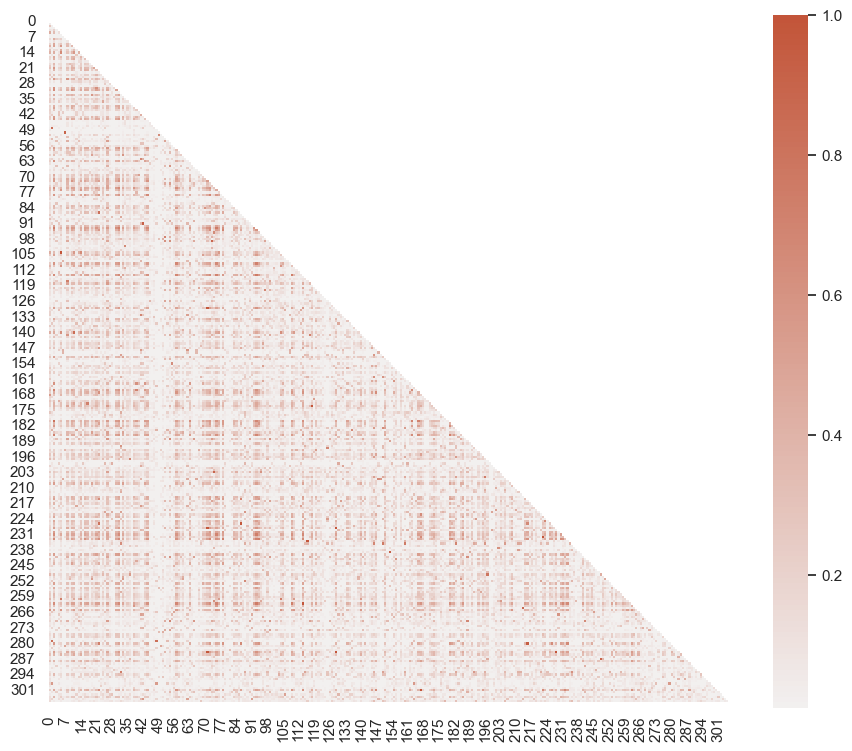

In [50]:
# Configure seaborn to set the plot style to 'white'
sns.set_theme(style="white")

# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))

# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(similarity_matrix, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)


In [51]:
similarity_df.to_csv('similarity_matrix.csv', index=True)